In [1]:
import psycopg2
from psycopg2 import sql
from psycopg2.extensions import adapt, register_adapter, AsIs
from sqlalchemy import create_engine
import getpass
import pandas as pd
import numpy as np

import pandas as pd
import geopandas as gpd
import os
import webbrowser
import numpy as np
from shapely import wkt
from datetime import datetime

In [ ]:
database = 'f24t03'
user = 'jsmm8'
password = getpass.getpass("Type password and hit enter: ")

Type password and hit enter: ········


In [ ]:
try:
    # Connect to the PostgreSQL database
    connection = psycopg2.connect(dbname=database, user=user, password=password, host='pgsql')
    cursor = connection.cursor()

    # Execute a query to get all table names
    cursor.execute("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public';
    """)
    
    # Fetch all results
    tables = cursor.fetchall()

    # Print the table names
    print("Tables in the database:")
    for table in tables:
        print(table[0])

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()

Tables in the database:
ethnicity
year_built
springfield_fire
education_levels
springfield_middle_school
tenure_by_bedrooms
tenure_by_kitchen
tenure_by_plumbing
rooms
imputed_median_house_value
raster_columns
raster_overviews
springfield_police
education_categories
demographics_master
model_features_data
year_structure_built
springfield_early_childhood_school
mortgage
tenure_by_rooms
income_data_processed
race_data_processed
housing_stats_data
race_migration_data
merged_new_house_data
income_pct_change
bedrooms
distance_drive_times
educational_attainment
employment_status
springfield_neighborhood_service_areas
parcel_boundaries
springfield_final_dataset
geo_mobility
home_value
house_heating_fuel
household_income
housing_pct_change_stats_data
internet_subscription
income_to_poverty_ratio
median_home_value
median_household_income
median_rooms_by_tenure
occupancy_status
plumbing_facilities
poverty_status
mortgage_status
springfield_single_family_point
springfield_elementary_school
springf

In [ ]:
# Full data

# === Step 1: Connect to your database ===
conn = psycopg2.connect(database=database, user=user, host='pgsql', password=password)

# === Step 2: Load full table using pandas ===
query = "SELECT * FROM georealedge_data;"
df = pd.read_sql(query, conn)
conn.close()

# === Step 3: Identify all geometry columns ===
geometry_cols = [col for col in df.columns if 'geolocation' in col]

# === Step 4: Convert all geometry columns from WKB to Shapely Points ===
from shapely import wkb

def safe_parse(val):
    try:
        if isinstance(val, str):
            return wkb.loads(val, hex=True)
        elif isinstance(val, (bytes, memoryview)):
            return wkb.loads(val)
    except:
        return None

for col in geometry_cols:
    df[col] = df[col].apply(safe_parse)

# === Step 5: Wrap as GeoDataFrame using one geometry column ===
df_full = gpd.GeoDataFrame(df, geometry='home_geolocation', crs='EPSG:26915')

df_full.head()

,home_geolocation,block_group_id,address,objectid,zip5,nsa,bds_zone,zoning,drive_time_fire,drive_distance_fire,...,square_footage,lot_size,year_built,sinkhole_house_risk_rating,sinkhole_risk_label,has_sinkhole_impact,pct_fld_oc,has_floodplain_impact,floodplain_house_risk_rating,floodplain_risk_label
0,POINT (471174.694 4120899.099),1500000US290770033003,2511 W ATLANTIC ST,6720,65803,TOM WATKIN,A,R-SF,2.75,0.92,...,2358,10688.0,2019,0,No Risk,N,0.0,N,0,No Risk
1,POINT (472875.801 4120913.727),1500000US290770019001,2027 N JOHNSTON AVE,52747,65803,WOODLAND,A,R-SF,3.30,0.98,...,2947,19842.0,1971,0,No Risk,N,0.0,N,0,No Risk
2,POINT (473810.378 4120914.316),1500000US290770019002,2031 N LYON AVE,56844,65803,WOODLAND,BN,R-SF,1.89,0.54,...,3388,19634.0,1979,0,No Risk,N,0.0,N,0,No Risk
3,POINT (471548.433 4120914.286),1500000US290770033003,2014 N PARK AVE,38608,65803,TOM WATKIN,A,R-SF,3.17,1.14,...,2832,21306.0,2014,0,No Risk,N,0.0,N,0,No Risk
4,POINT (474571.749 4120917.463),1500000US290770055003,2040 N BENTON AVE,5218,65803,WOODLAND,BN,R-SF,3.22,0.92,...,2594,10017.0,1962,0,No Risk,N,0.0,N,0,No Risk


In [5]:
# Drop rows with missing values in the three stratifying columns
df_valid = df_full[
    df_full[['nsa', 'has_sinkhole_impact', 'has_floodplain_impact']].notnull().all(axis=1)
]

# Sampling function for each NSA group
def triple_stratified_sample(group):
    total_target = 100
    
    # Group by both sinkhole and floodplain impact
    strat_group = group.groupby(['has_sinkhole_impact', 'has_floodplain_impact'])
    
    # Count samples per subgroup
    subgroup_counts = strat_group.size().reset_index(name='count')
    
    if subgroup_counts.empty:
        return pd.DataFrame()
    
    # Determine proportions
    subgroup_counts['proportion'] = subgroup_counts['count'] / subgroup_counts['count'].sum()
    subgroup_counts['sample_size'] = (subgroup_counts['proportion'] * total_target).round().astype(int)
    
    sampled_rows = []
    
    for _, row in subgroup_counts.iterrows():
        y_n = row['has_sinkhole_impact']
        f_n = row['has_floodplain_impact']
        n_sample = row['sample_size']
        
        sub_df = group[
            (group['has_sinkhole_impact'] == y_n) &
            (group['has_floodplain_impact'] == f_n)
        ]
        
        if len(sub_df) == 0:
            continue
        
        sample = sub_df.sample(n=n_sample, replace=(len(sub_df) < n_sample), random_state=42)
        sampled_rows.append(sample)
    
    return pd.concat(sampled_rows)

# Apply the sampling to each NSA
df_final_sample = df_valid.groupby('nsa', group_keys=False).apply(triple_stratified_sample)

In [6]:
df_final_sample

,home_geolocation,block_group_id,address,objectid,zip5,nsa,bds_zone,zoning,drive_time_fire,drive_distance_fire,...,square_footage,lot_size,year_built,sinkhole_house_risk_rating,sinkhole_risk_label,has_sinkhole_impact,pct_fld_oc,has_floodplain_impact,floodplain_house_risk_rating,floodplain_risk_label
32630,POINT (476953.017 4117407.434),1500000US290770023003,1919 E CHERRYSTREET CT,44094,65802,BINGHAM,C,R-SF,2.87,0.93,...,2778,15158.0,2020,0,No Risk,N,0.0,N,0,No Risk
31894,POINT (476967.327 4117275.622),1500000US290770023003,1913 E MONROE ST,44084,65802,BINGHAM,C,R-SF,3.60,1.10,...,4000,17968.0,2006,0,No Risk,N,0.0,N,0,No Risk
34670,POINT (478872.470 4117847.950),1500000US290770023002,314 S KEN AVE,50604,65802,BINGHAM,C,R-SF,3.14,1.19,...,2741,14677.0,1981,0,No Risk,N,0.0,N,0,No Risk
30629,POINT (477198.535 4117085.964),1500000US290770023003,747 S GRANDVIEW AVE,43861,65802,BINGHAM,C,R-SF,3.30,1.02,...,3915,18973.0,1983,0,No Risk,N,0.0,N,0,No Risk
33734,POINT (478708.373 4117642.303),1500000US290770023002,426 S MONTE VISTA AVE,69580,65802,BINGHAM,C,R-SF,3.67,1.26,...,2157,18491.0,1963,0,No Risk,N,0.0,N,0,No Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5179,POINT (478581.566 4106534.401),1500000US290770040021,5917 S AUDREY CT,101166,65804,ZONE4,C,R-SF,0.80,0.22,...,2015,19946.0,2015,0,No Risk,N,0.0,N,0,No Risk
8255,POINT (474394.251 4110128.349),1500000US290770040041,4231 S KIMBROUGH AVE,31558,65810,ZONE4,BS,R-SF,4.19,1.75,...,3699,13796.0,1967,0,No Risk,N,0.0,N,0,No Risk
19330,POINT (480543.545 4114431.966),1500000US290770038022,3665 E BOWMAN ST,30132,65809,ZONE4,C,R-SF,1.62,0.57,...,3220,17238.0,2004,0,No Risk,N,0.0,N,0,No Risk
15262,POINT (481068.078 4113411.671),1500000US290770038023,3977 E WILSHIRE DR,38517,65809,ZONE4,C,R-SF,0.05,0.01,...,3469,20834.0,1961,0,No Risk,N,0.0,N,0,No Risk


In [7]:
df = df_final_sample.copy()

In [8]:
df_filtered = df[
    (df['house_price'] >= 140000) &
    (df['house_price'] <= 300000) &
    (df['bedrooms'] == 3) &
    (df['bathrooms'] == 3) &
    (df['square_footage'] >= 1000) &
    (df['square_footage'] <= 4500)
].copy()

poi_columns = [
    "drive_distance_hospital",
    "drive_distance_early_childhood_school",
    "drive_distance_trailheads",
    "drive_distance_urgentcare"
]

# Piecewise scoring function
def piecewise_score(distance, threshold):
    if distance <= threshold:
        return 1.00
    elif distance <= threshold + 1:
        return 0.85
    elif distance <= threshold + 2:
        return 0.70
    elif distance <= threshold + 3:
        return 0.55
    elif distance <= threshold + 4:
        return 0.40
    else:
        return 0.25

def compute_scores(df, distance_adjustment, round_number):
    poi_prefs = {
        "drive_distance_hospital": {"importance": 5, "threshold": 4 + distance_adjustment},
        "drive_distance_early_childhood_school": {"importance": 4, "threshold": 4 + distance_adjustment},
        "drive_distance_trailheads": {"importance": 4, "threshold": 3 + distance_adjustment},
        "drive_distance_urgentcare": {"importance": 3, "threshold": 4 + distance_adjustment},
    }

    weights = {k: v['importance'] for k, v in poi_prefs.items()}
    total_weight = sum(weights.values())
    weights = {k: v / total_weight for k, v in weights.items()}

    for poi in poi_prefs:
        score_col = f"{poi}_score_r{round_number}"
        threshold = poi_prefs[poi]["threshold"]
        df[score_col] = df[poi].apply(lambda x: piecewise_score(x, threshold))

    df[f"final_score_r{round_number}"] = df.apply(
        lambda row: sum(row[f"{poi}_score_r{round_number}"] * weights[poi] for poi in poi_prefs),
        axis=1
    )
    return df

df_filtered = compute_scores(df_filtered, 0, 1)
df_filtered = compute_scores(df_filtered, -1, 2)
df_filtered = compute_scores(df_filtered, 1, 3)

comparison_cols = ["address"] + poi_columns + [
    "final_score_r1", "final_score_r2", "final_score_r3"
]
df_comparison = df_filtered[comparison_cols].copy()

rename_map = {
    "drive_distance_hospital": "Hospital (mi)",
    "drive_distance_early_childhood_school": "Early Childhood (mi)",
    "drive_distance_trailheads": "Trailheads (mi)",
    "drive_distance_urgentcare": "Urgent Care (mi)",
    "final_score_r1": "Score R1",
    "final_score_r2": "Score R2",
    "final_score_r3": "Score R3"
}
df_comparison = df_comparison.rename(columns=rename_map)

In [9]:
df_comparison = df_comparison.reset_index().drop(columns='index')

In [10]:
df_comparison.sort_values(by="Score R1", ascending=False).reset_index(drop=True)

,address,Hospital (mi),Early Childhood (mi),Trailheads (mi),Urgent Care (mi),Score R1,Score R2,Score R3
0,2632 E STANFORD ST,2.18,3.35,0.70,3.75,1.000000,0.934375,1.0000
1,1354 S FAIRWAY AVE,1.39,3.87,1.45,2.44,1.000000,0.962500,1.0000
2,1044 W LINDBERG ST,1.95,3.45,1.31,3.13,1.000000,0.934375,1.0000
3,1725 E LOMBARD ST,2.09,3.14,2.28,1.70,1.000000,0.925000,1.0000
4,951 S WELLER AVE,1.72,3.54,1.68,2.10,1.000000,0.962500,1.0000
5,1340 N BENTON AVE,0.18,2.79,1.09,1.82,1.000000,1.000000,1.0000
6,1239 N JEFFERSON AVE,0.20,2.78,0.78,2.01,1.000000,1.000000,1.0000
7,1703 N SHERMAN AVE,0.88,2.45,0.74,1.47,1.000000,1.000000,1.0000
8,840 S WELLER AVE,1.85,3.41,1.81,1.97,1.000000,0.962500,1.0000
9,2451 E KIRKWOOD ST,2.04,3.99,0.34,3.13,1.000000,0.934375,1.0000


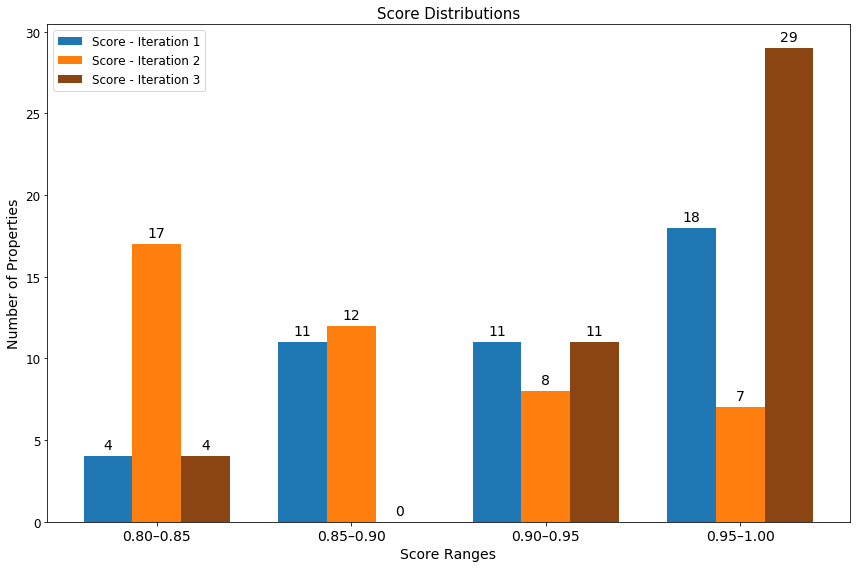

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bins = [0.80, 0.85, 0.90, 0.95, 1.00]
labels = ["0.80–0.85", "0.85–0.90", "0.90–0.95", "0.95–1.00"]

r1_bins = pd.cut(df_comparison["Score R1"], bins=bins, labels=labels, include_lowest=True)
r2_bins = pd.cut(df_comparison["Score R2"], bins=bins, labels=labels, include_lowest=True)
r3_bins = pd.cut(df_comparison["Score R3"], bins=bins, labels=labels, include_lowest=True)

r1_counts = r1_bins.value_counts().sort_index()
r2_counts = r2_bins.value_counts().sort_index()
r3_counts = r3_bins.value_counts().sort_index()

x = np.arange(len(labels))
width = 0.25

colors = ['#1f77b4', '#ff7f0e', '#8B4513']


plt.figure(figsize=(12, 8))

bars1 = plt.bar(x - width, r1_counts, width=width, color=colors[0], label='Score - Iteration 1')
bars2 = plt.bar(x,         r2_counts, width=width, color=colors[1], label='Score - Iteration 2')
bars3 = plt.bar(x + width, r3_counts, width=width, color=colors[2], label='Score - Iteration 3')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 4),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=14)

plt.xticks(x, labels, fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel("Score Ranges", fontsize=14)
plt.ylabel("Number of Properties", fontsize=14)
plt.title("Score Distributions", fontsize=15)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
# Scenario 1

import pandas as pd

def piecewise_score(distance, threshold):
    """Calculate score based on distance from threshold"""
    if distance <= threshold:
        return 1.00
    elif distance <= threshold + 1:
        return 0.85
    elif distance <= threshold + 2:
        return 0.70
    elif distance <= threshold + 3:
        return 0.55
    elif distance <= threshold + 4:
        return 0.40
    else:
        return 0.25

def main():
    print(f"Successfully loaded data with {len(df)} records")

    # Fixed Filters
    df_filtered = df[
        (df['house_price'] >= 140000) &
        (df['house_price'] <= 300000) &
        (df['bedrooms'] == 3) &
        (df['bathrooms'] == 3) &
        (df['square_footage'] >= 1000) &
        (df['square_footage'] <= 4500)
    ].copy()

    print(f"After filtering: {len(df_filtered)} records remain")

    # POI Preferences - hardcoded
    poi_preferences = {
        "drive_distance_hospital": {"importance": 5, "threshold": 4},
        "drive_distance_early_childhood_school": {"importance": 4, "threshold": 4},
        "drive_distance_trailheads": {"importance": 4, "threshold": 3},
        "drive_distance_urgentcare": {"importance": 3, "threshold": 4}
    }

    scored_df = df_filtered.copy()
    total_importance = sum(p['importance'] for p in poi_preferences.values())
    weights = {k: v['importance'] / total_importance for k, v in poi_preferences.items()}

    for poi, prefs in poi_preferences.items():
        scored_df[f"{poi}_score"] = scored_df[poi].apply(lambda x: piecewise_score(x, prefs['threshold']))

    scored_df["final_score"] = scored_df.apply(
        lambda row: sum(row[f"{poi}_score"] * weights[poi] for poi in poi_preferences),
        axis=1
    )

    scored_df = scored_df.sort_values("final_score", ascending=False)

    print("\n===== MATCHING PROPERTIES =====")
    base_columns = ["address", "final_score"]
    display_columns = base_columns

    print(scored_df[display_columns].round(2))

if __name__ == "__main__":
    main()

Successfully loaded data with 3600 records
After filtering: 44 records remain

===== MATCHING PROPERTIES =====
                      address  final_score
22266      2632 E STANFORD ST         1.00
25583      1354 S FAIRWAY AVE         1.00
19634      1044 W LINDBERG ST         1.00
29823       1725 E LOMBARD ST         1.00
29010        951 S WELLER AVE         1.00
40070       1340 N BENTON AVE         1.00
39470    1239 N JEFFERSON AVE         1.00
41675      1703 N SHERMAN AVE         1.00
29963        840 S WELLER AVE         1.00
19343      2451 E KIRKWOOD ST         1.00
24516       1447 S BARNES AVE         1.00
22915      2951 E PORTLAND ST         1.00
33746  3746 W MOUNT VERNON ST         0.97
18017     3133 E SEMINOLE CIR         0.96
20921      2871 E EASTMOOR DR         0.96
22524     1727 S KENTWOOD AVE         0.96
18280      2385 E SEMINOLE ST         0.96
4538       3127 N OAKLAND AVE         0.96
13596     1039 E GUINEVERE ST         0.92
14775       725 E EDGEWOOD ST

In [14]:
# Scenario 2

import pandas as pd

def piecewise_score(distance, threshold):
    """Calculate score based on distance from threshold"""
    if distance <= threshold:
        return 1.00
    elif distance <= threshold + 1:
        return 0.90
    elif distance <= threshold + 2:
        return 0.80
    elif distance <= threshold + 3:
        return 0.70
    elif distance <= threshold + 4:
        return 0.60
    elif distance <= threshold + 5:
        return 0.50
    elif distance <= threshold + 6:
        return 0.40
    else:
        return 0.30

def main():
    print(f"Successfully loaded data with {len(df)} records")

    # Fixed Filters
    df_filtered = df[
        (df['house_price'] >= 140000) &
        (df['house_price'] <= 300000) &
        (df['bedrooms'] == 3) &
        (df['bathrooms'] == 3) &
        (df['square_footage'] >= 1000) &
        (df['square_footage'] <= 4500)
    ].copy()

    print(f"After filtering: {len(df_filtered)} records remain")

    # POI Preferences - hardcoded
    poi_preferences = {
        "drive_distance_hospital": {"importance": 5, "threshold": 4},
        "drive_distance_early_childhood_school": {"importance": 4, "threshold": 4},
        "drive_distance_trailheads": {"importance": 4, "threshold": 3},
        "drive_distance_urgentcare": {"importance": 3, "threshold": 4}
    }

    scored_df = df_filtered.copy()
    total_importance = sum(p['importance'] for p in poi_preferences.values())
    weights = {k: v['importance'] / total_importance for k, v in poi_preferences.items()}

    for poi, prefs in poi_preferences.items():
        scored_df[f"{poi}_score"] = scored_df[poi].apply(lambda x: piecewise_score(x, prefs['threshold']))

    scored_df["final_score"] = scored_df.apply(
        lambda row: sum(row[f"{poi}_score"] * weights[poi] for poi in poi_preferences),
        axis=1
    )

    scored_df = scored_df.sort_values("final_score", ascending=False)

    print("\n===== MATCHING PROPERTIES =====")
    base_columns = ["address", "final_score"]
    display_columns = base_columns

    print(scored_df[display_columns].round(2))

if __name__ == "__main__":
    main()

Successfully loaded data with 3600 records
After filtering: 44 records remain

===== MATCHING PROPERTIES =====
                      address  final_score
22266      2632 E STANFORD ST         1.00
25583      1354 S FAIRWAY AVE         1.00
19634      1044 W LINDBERG ST         1.00
29823       1725 E LOMBARD ST         1.00
29010        951 S WELLER AVE         1.00
40070       1340 N BENTON AVE         1.00
39470    1239 N JEFFERSON AVE         1.00
41675      1703 N SHERMAN AVE         1.00
29963        840 S WELLER AVE         1.00
19343      2451 E KIRKWOOD ST         1.00
24516       1447 S BARNES AVE         1.00
22915      2951 E PORTLAND ST         1.00
33746  3746 W MOUNT VERNON ST         0.98
18017     3133 E SEMINOLE CIR         0.98
20921      2871 E EASTMOOR DR         0.98
22524     1727 S KENTWOOD AVE         0.98
18280      2385 E SEMINOLE ST         0.98
4538       3127 N OAKLAND AVE         0.98
13596     1039 E GUINEVERE ST         0.95
14775       725 E EDGEWOOD ST

In [15]:
# Scenario 3

import pandas as pd

def piecewise_score(distance, threshold):
    """Calculate score based on distance from threshold"""
    if distance <= threshold:
        return 1.00
    elif distance <= threshold + 0.5:
        return 0.90
    elif distance <= threshold + 1:
        return 0.80
    elif distance <= threshold + 1.5:
        return 0.70
    elif distance <= threshold + 2:
        return 0.60
    elif distance <= threshold + 2.5:
        return 0.50
    elif distance <= threshold + 3:
        return 0.40
    elif distance <= threshold + 3.5:
        return 0.30
    else:
        return 0.20

def main():
    print(f"Successfully loaded data with {len(df)} records")

    # Fixed Filters
    df_filtered = df[
        (df['house_price'] >= 140000) &
        (df['house_price'] <= 300000) &
        (df['bedrooms'] == 3) &
        (df['bathrooms'] == 3) &
        (df['square_footage'] >= 1000) &
        (df['square_footage'] <= 4500)
    ].copy()

    print(f"After filtering: {len(df_filtered)} records remain")

    # POI Preferences - hardcoded
    poi_preferences = {
        "drive_distance_hospital": {"importance": 5, "threshold": 4},
        "drive_distance_early_childhood_school": {"importance": 4, "threshold": 4},
        "drive_distance_trailheads": {"importance": 4, "threshold": 3},
        "drive_distance_urgentcare": {"importance": 3, "threshold": 4}
    }

    scored_df = df_filtered.copy()
    total_importance = sum(p['importance'] for p in poi_preferences.values())
    weights = {k: v['importance'] / total_importance for k, v in poi_preferences.items()}

    for poi, prefs in poi_preferences.items():
        scored_df[f"{poi}_score"] = scored_df[poi].apply(lambda x: piecewise_score(x, prefs['threshold']))

    scored_df["final_score"] = scored_df.apply(
        lambda row: sum(row[f"{poi}_score"] * weights[poi] for poi in poi_preferences),
        axis=1
    )

    scored_df = scored_df.sort_values("final_score", ascending=False)

    print("\n===== MATCHING PROPERTIES =====")
    base_columns = ["address", "final_score"]
    display_columns = base_columns
    
    print(scored_df[display_columns].round(2))

if __name__ == "__main__":
    main()

Successfully loaded data with 3600 records
After filtering: 44 records remain

===== MATCHING PROPERTIES =====
                      address  final_score
29010        951 S WELLER AVE         1.00
19634      1044 W LINDBERG ST         1.00
29823       1725 E LOMBARD ST         1.00
29963        840 S WELLER AVE         1.00
22915      2951 E PORTLAND ST         1.00
19343      2451 E KIRKWOOD ST         1.00
24516       1447 S BARNES AVE         1.00
22266      2632 E STANFORD ST         1.00
25583      1354 S FAIRWAY AVE         1.00
41675      1703 N SHERMAN AVE         1.00
39470    1239 N JEFFERSON AVE         1.00
40070       1340 N BENTON AVE         1.00
33746  3746 W MOUNT VERNON ST         0.98
20921      2871 E EASTMOOR DR         0.98
22524     1727 S KENTWOOD AVE         0.98
4538       3127 N OAKLAND AVE         0.98
18280      2385 E SEMINOLE ST         0.98
18017     3133 E SEMINOLE CIR         0.95
18253       2311 S GOLDEN AVE         0.93
14775       725 E EDGEWOOD ST

In [16]:
# Scenario 4

import pandas as pd

def piecewise_score(distance, threshold):
    """Calculate score based on distance from threshold"""
    if distance <= threshold:
        return 1.00
    elif distance <= threshold + 0.5:
        return 0.95
    elif distance <= threshold + 1:
        return 0.90
    elif distance <= threshold + 1.5:
        return 0.85
    elif distance <= threshold + 2:
        return 0.80
    elif distance <= threshold + 2.5:
        return 0.75
    elif distance <= threshold + 3:
        return 0.70
    elif distance <= threshold + 3.5:
        return 0.65
    elif distance <= threshold + 4:
        return 0.60
    elif distance <= threshold + 4.5:
        return 0.55
    else:
        return 0.50

def main():
    print(f"Successfully loaded data with {len(df)} records")

    # Fixed Filters
    df_filtered = df[
        (df['house_price'] >= 140000) &
        (df['house_price'] <= 300000) &
        (df['bedrooms'] == 3) &
        (df['bathrooms'] == 3) &
        (df['square_footage'] >= 1000) &
        (df['square_footage'] <= 4500)
    ].copy()

    print(f"After filtering: {len(df_filtered)} records remain")

    # POI Preferences
    poi_preferences = {
        "drive_distance_hospital": {"importance": 5, "threshold": 4},
        "drive_distance_early_childhood_school": {"importance": 4, "threshold": 4},
        "drive_distance_trailheads": {"importance": 4, "threshold": 3},
        "drive_distance_urgentcare": {"importance": 3, "threshold": 4}
    }

    scored_df = df_filtered.copy()
    total_importance = sum(p['importance'] for p in poi_preferences.values())
    weights = {k: v['importance'] / total_importance for k, v in poi_preferences.items()}

    for poi, prefs in poi_preferences.items():
        scored_df[f"{poi}_score"] = scored_df[poi].apply(lambda x: piecewise_score(x, prefs['threshold']))

    scored_df["final_score"] = scored_df.apply(
        lambda row: sum(row[f"{poi}_score"] * weights[poi] for poi in poi_preferences),
        axis=1
    )

    scored_df = scored_df.sort_values("final_score", ascending=False)

    print("\n===== MATCHING PROPERTIES =====")
    base_columns = ["address", "final_score"]
    display_columns = base_columns

    print(scored_df[display_columns].round(2))

if __name__ == "__main__":
    main()

Successfully loaded data with 3600 records
After filtering: 44 records remain

===== MATCHING PROPERTIES =====
                      address  final_score
29010        951 S WELLER AVE         1.00
19634      1044 W LINDBERG ST         1.00
29823       1725 E LOMBARD ST         1.00
29963        840 S WELLER AVE         1.00
22915      2951 E PORTLAND ST         1.00
19343      2451 E KIRKWOOD ST         1.00
24516       1447 S BARNES AVE         1.00
22266      2632 E STANFORD ST         1.00
25583      1354 S FAIRWAY AVE         1.00
41675      1703 N SHERMAN AVE         1.00
39470    1239 N JEFFERSON AVE         1.00
40070       1340 N BENTON AVE         1.00
33746  3746 W MOUNT VERNON ST         0.99
20921      2871 E EASTMOOR DR         0.99
22524     1727 S KENTWOOD AVE         0.99
4538       3127 N OAKLAND AVE         0.99
18280      2385 E SEMINOLE ST         0.99
18017     3133 E SEMINOLE CIR         0.98
18253       2311 S GOLDEN AVE         0.97
14775       725 E EDGEWOOD ST

In [17]:
# topsis validation through data

def normalize_matrix(matrix):
    return matrix / np.sqrt((matrix ** 2).sum())


def topsis_score(df, criteria_columns, weights):
    decision_matrix = df[criteria_columns].copy()
    norm_matrix = normalize_matrix(decision_matrix)
    weighted_matrix = norm_matrix * weights

    pis = weighted_matrix.min()  
    nis = weighted_matrix.max()

    d_pos = np.sqrt(((weighted_matrix - pis) ** 2).sum(axis=1))
    d_neg = np.sqrt(((weighted_matrix - nis) ** 2).sum(axis=1))
    scores = d_neg / (d_pos + d_neg)

    return scores


def main():
    print(f"Successfully loaded data with {len(df)} records")

    use_filters = input("Do you want to apply filters? (y/n): ").lower() == 'y'
    if use_filters:
        min_price = float(input("Enter minimum price: ") or 0)
        max_price = float(input("Enter maximum price: ") or 1000000)

        bedrooms_input = input("Enter number of bedrooms (or press Enter for any): ")
        bedrooms = int(bedrooms_input) if bedrooms_input.strip() else None

        bathrooms_input = input("Enter number of bathrooms (or press Enter for any): ")
        bathrooms = float(bathrooms_input) if bathrooms_input.strip() else None

        min_sqft = float(input("Enter minimum square footage: ") or 0)
        max_sqft = float(input("Enter maximum square footage: ") or 10000)

        filtered_df = df[
            (df['house_price'] >= min_price) &
            (df['house_price'] <= max_price) &
            (df['square_footage'] >= min_sqft) &
            (df['square_footage'] <= max_sqft)
        ]

        if bedrooms is not None:
            filtered_df = filtered_df[filtered_df['bedrooms'] == bedrooms]

        if bathrooms is not None:
            filtered_df = filtered_df[filtered_df['bathrooms'] == bathrooms]

        print(f"After filtering: {len(filtered_df)} records remain")
    else:
        filtered_df = df.copy()

    distance_columns = [col for col in filtered_df.columns if 'drive_distance_' in col]

    print("\nAvailable Points of Interest:")
    for i, col in enumerate(distance_columns, 1):
        print(f"{i}. {col.replace('drive_distance_', '')}")

    poi_preferences = []

    while True:
        choice = int(input("\nSelect a POI (1-{0}) or 0 to finish: ".format(len(distance_columns))))
        if choice == 0:
            break

        if 1 <= choice <= len(distance_columns):
            selected_column = distance_columns[choice - 1]
            importance = int(input(f"How important is it for this POI ({selected_column.replace('drive_distance_', '')}) to be CLOSE to the property? (1-5): "))

            poi_preferences.append({
                'column': selected_column,
                'importance': importance
            })
            print(f"Added {selected_column.replace('drive_distance_', '')}")
        else:
            print("Invalid choice")

    if not poi_preferences:
        print("No POIs selected. Exiting.")
        return

    scored_df = filtered_df.copy()

    selected_pois = [poi['column'] for poi in poi_preferences]
    importance = {poi['column']: poi['importance'] for poi in poi_preferences}

    total_importance = sum(importance.values())
    weights = np.array([importance[poi] / total_importance for poi in selected_pois])

    # Calculate TOPSIS scores
    scored_df["topsis_score"] = topsis_score(scored_df, selected_pois, weights)
    scored_df = scored_df.sort_values("topsis_score", ascending=False)

    print("\n===== PROPERTIES RANKED BY TOPSIS SCORE =====")
    display_columns = ["address", "house_price", "bedrooms", "bathrooms", "square_footage"] + selected_pois + ["topsis_score"]
    print(scored_df[display_columns].round(2).to_string(index=False))
    

if __name__ == "__main__":
    main()

Successfully loaded data with 3600 records
Do you want to apply filters? (y/n): y
Enter minimum price: 45000
Enter maximum price: 7500000
Enter number of bedrooms (or press Enter for any): 3
Enter number of bathrooms (or press Enter for any): 2
Enter minimum square footage: 1000
Enter maximum square footage: 4500
After filtering: 133 records remain

Available Points of Interest:
1. fire
2. police
3. early_childhood_school
4. elementary_school
5. middle_school
6. high_school
7. hospital
8. nursing_home
9. public_health
10. urgentcare
11. trailheads

Select a POI (1-11) or 0 to finish: 7
How important is it for this POI (hospital) to be CLOSE to the property? (1-5): 5
Added hospital

Select a POI (1-11) or 0 to finish: 10
How important is it for this POI (urgentcare) to be CLOSE to the property? (1-5): 4
Added urgentcare

Select a POI (1-11) or 0 to finish: 0

===== PROPERTIES RANKED BY TOPSIS SCORE =====
                 address  house_price  bedrooms  bathrooms  square_footage  drive_d